## Script is capable to work with files that contain simulation data of particular layout

In [1]:
%pylab inline

import sys
sys.path.append( "D:/shamil_docs/jupyter_dir/lib" ) # include path with resonator_tools module
from resonator_tools.circuit import notch_port
from os import listdir
from os.path import isfile, join
import csv

from collections import Counter
from copy import deepcopy

# abs path to dir that contain csv files with data to plot
dir_name = "D:/shamil_docs/Qubit projects/Transmission_line_with_flux_qbits_in_resonators/Resonator_Qfactor_sonnet_6GHz_to_9GHz/csv_data/"

Populating the interactive namespace from numpy and matplotlib


## Important notes
".csv" files may contain data exported from sonnet with the following way:
"sonnet response viewer -> output-> S,Z,Y parameters -> (format list) = spreadsheet"
and the second format parameter should be set to "Mag-Angle"

every file may contain multiple sweeps 
(in case you made parameter or any other multiple data 
sweep and want to save all of the results in single file)
any such files should be marked with keyword "_multi" in the end of it's name

if file contains single sweep (in case it is to hard to parametrize sophisticated design)
parameters should be stored in it's name in the following format:
"Transmission_line_with_resonator_6GHz_toLine_40_Lcoupling_100_Z0b_20"
(all parameter names and their values must be separated by underscore)

"### CUSTOMIZATION SECTION ... ###" sections reflect that they are unique for specified design or parameter combinations and should be modified by user manually

## Single file fitting and plotting

In [ ]:
file_name = "1_Transmission_line_with_resonator_6GHz_Lcoupling_400_toLine_35"
with open(dir_name + file_name + ".csv") as f:
    data = list(csv.reader(f, delimiter=" "))
[data.pop(0) for i in range(8)] # get rid of context strings in file header
freq = np.zeros( len(data), dtype=np.float64 )
s21_amp = np.zeros( len(data), dtype=np.float64 )
s21_phase = np.zeros( len(data), dtype=np.float64 )
for i,row in enumerate(data):
    freq[i] = row[0]
    s21_amp[i] = row[3]
    s21_phase[i] = row[4]
s21_phase *= np.pi/180

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5,7), sharex=True)
axes[0].plot(freq,s21_amp)
axes[1].plot(freq,s21_phase)
axes[0].set_ylabel("$|S_{21}^2|$ [dB]")
axes[1].set_ylabel(r"$\angle S_{21}$ [rad]")
axes[1].set_xlabel("Frequency [GHz]")
plt.savefig("sim_res_S21.pdf", bbox_inches="tight")

In [ ]:
port1 = notch_port( freq, s21_amp*np.exp( 1j*s21_phase ) )
port1.autofit()
port1.fitresults

In [ ]:
port1.plotall()

## Fitting all files and storing them into "Results.csv" that is compatible with Excel 2010 format

In [2]:
def is_number( val ):
    try:
        float( val )
        return True
    except ValueError:
        return False
    
def add_default( params_in_file, param_defaults ):
    for key,val in params_in_file.items(): 
        if( val == None ):
            params_in_file[key] = param_defaults[key]
            
def load_csv_from_dir( dir_name, param_names, param_defaults ):
    '''
    @description: 
    function loads ".csv" files from directory specified by 'dir_name'
    all this files should be generated by Sonnet Response viewer
    as a spreadsheets with format Mag-Angle
    function also maps data to parameter grid
    parameters names must be supplied through @param_names as list of strings
    parameters name must coicide with parameters in file names and with
    parameters defined inside Sonnet UI
    
    if file has multiple sweeps its name must end with "_multi.csv"
    this reflects that parameter combinations, defined inside the
    Sonnet UI, are stored inside the file
    example: "Transmission_line_with_resonator_6GHz_toLine_40_Lcoupling_100_to_400_Z0b_30_multi"
    in case there are some parameters that you are going to include into 
    parameter grid but they are not written by Sonnet in file content
    you may define their values in the file name,
    in format that corresponds for files containing sigle sweep
    
    if file contains single sweep it name must contain all of the parameters
    in the following format:
    "Transmission_line_with_resonator_6GHz_toLine_25_Lcoupling_100_Z0b_30"
    this name is interpreted as follows:
    toLine = 25
    Lcoupling = 100
    Z0b = 30
    every parameter name must be followed by its value and every word
    is separated by uderscore
    
    @note: currently this function extracts only columns 4 and 5
            that corresponds to S21 parameters 05.08.2017
    
    
    parameters
    @dir_name: absolute path to directory with files
    @param_names: names of the parameters that will form parameter grid
                ["Lcoupling","toLine","Z0b"] 
    @param_defaults: dictionary with parameter names and their default values
                    this values will be used in case function can't determine 
                    some parameter value from file name or its content
                    {"Lcoupling":300,"toLine":50,"Z0b":30}
                    
    return: file_names, params, freqs, s21_data
    @file_names: file names that reflects origins of every
                s21_data element correspondingly 
                (file_names may have duplicates, since )
    @params: parameter name as list of strings
    @freqs: list of 1D numpy.arrays with dtype=np.float64 
            that stores frequency points that correspond to s21_data content
    @s21_data: list of 1D numpy.arrays with dtype=np.complex
                that stores actual s21_data points as complex numbers
    '''
    #"param_grid" stores all possible values of each parameter
    # [[p11,p12,p13,...],...,[pn1,pn2,...]] - first index is the parameter number
    param_grid = [[] for name in param_names] 
    # due to this approach every simulation data set should be assigned with coordinates
    # in this "parameter grid space" 
    #(coordinates are list of integers referring to point in param_grid)

    ### CUSTOMIZATION SECTION START ###
    # prepare calculated data attributes
    fit_results = [] # Qc - quality factor of every resonanse in scheme
    ### CUSTOMIZATION SECTION END ###


    # getting names of all files in the specified direcory "dir_name"
    file_names = [f for f in listdir(dir_name) if isfile(join(dir_name,f))]

    # filter only "csv" files
    file_lines = [f.split('_') for f in file_names]
    files = [f for i,f in enumerate(file_names) if file_lines[i][-1].split('.')[-1] == "csv"]

    freqs = []
    s_data = []
    params = []
    files_ret = []
    
    # exctracting parameter's grid from name of files or their content
    # mapping exctracted s_data to the grid
    # iterating over all "csv" files:
    for f_index,f in enumerate(file_lines):
        # handling files with particular parameters stored in their name
        if( f[-1].split('.')[0] != "multi" ): # in case if file store params in it's name
            params_in_file = {name:None for name in param_names}
            for param in param_names:
                params_in_file[param] = f[f.index(param) + 1].split('.')[0]
                # split('.') - in case of file name end with number e.g. "...30.csv"

                # adding default parameters 
                # if they were ommited in particular parameter group
                add_default( params_in_file, param_defaults )

            # setting parameters corresponding to the freqs and s_data
            # that are added in the code below
            params.append( [params_in_file[name] for name in param_names] )
            files_ret.append(file_names[f_index])
            with open( dir_name + files[f_index] ) as csv_file:
                # load the whole file
                file_rows = list( csv.reader(csv_file, delimiter=" ") )

                [file_rows.pop(0) for i in range(8)] # get rid of context strings in file header
                freq = np.zeros( len(file_rows), dtype=np.float64 )
                s21_amp = np.zeros( len(file_rows), dtype=np.float64 )
                s21_phase = np.zeros( len(file_rows), dtype=np.float64 )
                for i,row in enumerate(file_rows):
                    freq[i] = row[0]
                    s21_amp[i] = row[3]
                    s21_phase[i] = row[4]
                s21_phase *= np.pi/180
                freqs.append(freq)
                s_data.append( s21_amp*np.exp( 1j*s21_phase ) )


        else: # in case of multiparameter file
            # reading s21 parameters from file
            with open( dir_name + files[f_index] ) as csv_file:

                # getting local default parameters from file name
                param_local_defaults = {name:None for name in param_names}
                for param in param_names:
                    try:
                        param_local_defaults[param] = f[f.index(param) + 1].split('.')[0]
                    except ValueError:
                        pass
                    # split('.') - in case of file name end with number e.g. "...30.csv"

                # adding default parameters from global to local 
                # in case some of the parameters still omitted even in file name
                add_default( param_local_defaults, param_defaults )

                # load the whole file
                file_rows = list( csv.reader(csv_file, delimiter=",") )

                params_in_file = {name:None for name in param_names}
                current_row_i = 0
                while( current_row_i != len(file_rows) ): # if end of file is not reached
                    # scanning rows for parameter definition grop
                    group_found = False
                    while(True):
                        row = file_rows[current_row_i]
                        
                        # finding group of rows with specified parameters
                        words = row[0].split(' ')
                        if( len(words) > 1 and words[1] is "=" ):
                            group_found = True
                            # adding defined parameter
                            params_in_file[words[0]] = words[2]
                            current_row_i += 1
                            continue # move to the next row


                        # if all parameters is recorded and the first element is number
                        # add values to ommited parameters and read s_data and freq
                        if( (group_found is True) and is_number(row[0]) ):
                            # adding local default parameters 
                            # if they were ommited in particular parameter group
                            add_default( params_in_file, param_local_defaults )
                            # setting parameters corresponding to the freqs and s_data
                            # that are added in the code below
                            params.append( [params_in_file[name] for name in param_names] ) 
                            files_ret.append(file_names[f_index])
                            break # goto adding of s_data and freq
                        else: # move to the next row
                            current_row_i += 1

                    ## adding s-data that follows the parameter group ##
                    # counting length of freq and s_data
                    num_rows = 0
                    while( (current_row_i + num_rows) < len(file_rows) and 
                          is_number(file_rows[current_row_i + num_rows][0]) ): 
                          num_rows += 1 

                    # collecting data
                    this_freqs = np.zeros( num_rows, dtype=np.float64 )
                    this_s21_amp = np.zeros( num_rows, dtype=np.float64 )
                    this_s21_phase = np.zeros( num_rows, dtype=np.float64 )

                    # scanning through the data and collecting values
                    for offset in range(num_rows):
                        current_row = file_rows[current_row_i + offset]
                        this_freqs[offset] = current_row[0]
                        this_s21_amp[offset] = current_row[3]
                        this_s21_phase[offset] = current_row[4]

                    # storing values into s_data and freq
                    freqs.append( this_freqs )
                    this_s21_phase *= np.pi/180
                    s_data.append( this_s21_amp*np.exp(1j*this_s21_phase) )

                    # updating current row index
                    current_row_i += num_rows

    tup = tuple((tuple(x) for x in params))
    count = Counter(tup)
    for key,cnt in count.items():
        if( cnt > 1 ):
            positions = []
            for i,param_combination in enumerate(params):
                if( list(key) == param_combination ):
                    positions.append(i)
                    
            print( "non-unique parameter combination encountered: ", params[positions[0]])
            print( "duplicates are found in following files:" )
            for i in positions:
                print( files_ret[i] )
            
    return files_ret, params, freqs, s_data

def sort_by_params( param_indexes, params, list_to_sort ):
    sorted_zip = sorted( zip( params, list_to_sort ), \
                        key=lambda x: tuple((float(x[0][param_idx]) for param_idx in param_indexes)) )
    return [val for param,val in sorted_zip]

# main section

In [3]:
### CUSTOMIZATION SECTION START ###
# setting parameter list (made by programmer for every new design)
param_names = ["Lcoupling","toLine","Z0b"] 
param_defaults = {"Lcoupling":300,"toLine":50,"Z0b":30} # parameter values if they are not specified
# all of the parameters should be specified
# additional parameters are ignored
### CUSTOMIZATION SECTION END ###

files, params, freqs, s_data = load_csv_from_dir( dir_name, param_names, param_defaults )

### CUSTOMIZATION SECTION START ###
# sorting data
s_data = sort_by_params( [2,1,0], params, s_data )
freqs = sort_by_params( [2,1,0], params, freqs )
files = sort_by_params( [2,1,0], params, files )
params = sort_by_params( [2,1,0], params, params )
### CUSTOMIZATION SECTION END ###

D:/shamil_docs/jupyter_dir/lib\resonator_tools\circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if f_data!=None:
D:/shamil_docs/jupyter_dir/lib\resonator_tools\circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if z_data_raw!=None:
D:/shamil_docs/jupyter_dir/lib\resonator_tools\circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if cov!=None:
D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


[['100.0', '21.0', 30], ['200.0', '21.0', 30], ['300.0', '21.0', 30], ['400.0', '21.0', 30], ['100.0', '22.5', 30], ['200.0', '22.5', 30], ['300.0', '22.5', 30], ['400.0', '22.5', 30], ['100.0', '24.0', 30], ['200.0', '24.0', 30], ['300.0', '24.0', 30], ['400.0', '24.0', 30], ['100.0', '25.5', 30], ['200.0', '25.5', 30], ['300.0', '25.5', 30], ['400.0', '25.5', 30], ['100.0', '26.0', 30], ['200.0', '26.0', 30], ['300.0', '26.0', 30], ['400.0', '26.0', 30], ['400.0', '35.0', 30]]


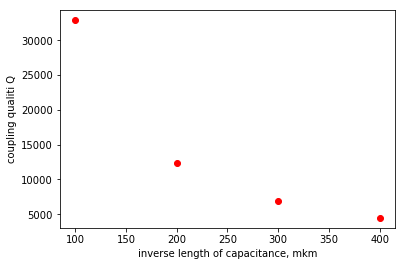

In [12]:
# fitting data results with resonator_tools.notch_port
fit_params = []
for i,data in enumerate(s_data):
    port1 = notch_port( freqs[i], data )
    port1.autofit()
    fit_params.append( port1.fitresults )

# saving results into ".csv" file
with open( dir_name + "../Results.csv", "w" ) as csv_file:
    writer = csv.writer( csv_file, delimiter=';', lineterminator='\n')
    writer.writerow( param_names + list(fit_params[0].keys()) )
    for i,result in enumerate(fit_params):
        writer.writerow( params[i] + list(result.values()) )

# plottig custom results
x_list = []
indexes = []

for i,param in enumerate(params):
    if( float(param[1])==21 and float(param[2]) == 30 ):
        x_list.append( float(param[0]) )
        indexes.append(i)
y_list = [fit_params[i]["absQc"] for i in indexes]

# plot from param routine
print( params )

fig = plt.figure()
plt.xlabel("inverse length of capacitance, mkm")
plt.ylabel("coupling qualiti Q")
plt.plot( x_list, y_list, 'ro' )
# visualizing parameter combination already obtained

# save results for mathematica file
with open( dir_name + "../cap_toLine_21.csv", "w" ) as csvfile:
    writer = csv.writer( csvfile )
    writer.writerow( x_list )
    writer.writerow( y_list )
